In [1]:
import os
import numpy as np
import pandas as pd
import io
import bson

In [2]:
from skimage.data import imread

In [3]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


/home/femianjc/anaconda2/envs/femiani/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Project 2 - Cdiscount's Image Classification Challenge

Group members: Xian Liu, Matthew Spinelli, Jie Wang

This notebook presents our attempt for [Cdiscount Image Classification Challenge](https://www.kaggle.com/c/cdiscount-image-classification-challenge). This notebook will be devided in to __FOUR__ chapters. Please click links to jump between chapters (may not work on github, __Unless we try to render this page first then post it on github maybe?__). All our modules are in "src" directory.

- [Pre-processing .bson input](#Pre-processing-bson-input)
- [Dataset overview](#Dataset-overview)
- [Deep learning architecture rationale: Computation graph & Training](#CNN-architecture)
- Conclusion

# Pre-processing bson input

  The dataset is provided in ".bson" format. [BSON](https://en.wikipedia.org/wiki/BSON) is short for Binary JSON, is a binary-encoded serialization of JSON-like documents, used with MongoDB. In non-relational databases like MongoDB, data is stored as (key:value) pairs.
  
  The training set provided contains a list of 7,069,896 dictionaries, one per product.Each dictionary contains a product id (key: _id), the category id of the product (key: category_id), and between 1-4 images, stored in a list (key: imgs). Each image list contains a single dictionary per image, which uses the format: {'picture': b'...binary string...'}. The binary string corresponds to a binary representation of the image in JPEG format.
  
  In this section we tackle the problem of randomly accessing all images by generating "lookup tables". 

In [27]:
from src.make_lookup_tables import *

In [4]:
DATA_DIR = "/home/femianjc/CSE627/Kaggle_Cdiscount_Image_Classification/data/"

In [13]:
data_df = pd.read_csv(os.path.join(DATA_DIR, "category_names.csv"))
data_df.head()

,category_id,category_level1,category_level2,category_level3
0,1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA
1,1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR
2,1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO
3,1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU
4,1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR


In [20]:
print "Total number of category entries:", len(data_df)
for c in data_df.columns:
    print "{} has {} unique values.".format(c, len(data_df[c].unique()))

Total number of category entries: 5270
category_id has 5270 unique values.
category_level1 has 49 unique values.
category_level2 has 483 unique values.
category_level3 has 5263 unique values.


The target problem requires us to classify 5263 categories, which is indeed an "extreme classification" problem. [ImageNet](http://image-net.org/), which often serves as a benchmark dataset in research papers, has only 1000 categories. Therefore, conventional image classification deep-learning architectures such as AlexNet, VGG-16 might not work on this dataset.

- First we map "category_id" to an integer for easier lookup. We can also use this number to generate one-hot label for products. 

In [21]:
# making category_id -> category_idx lookup table
# make_categories_df(os.path.join(DATA_DIR, "category_names.csv"))

categories_df = pd.read_csv(os.path.join(DATA_DIR, "categories.csv"), index_col=0)
categories_df.head()

,category_level1,category_level2,category_level3,level1_idx,level2_idx,category_idx,category_level1_EN,category_level2_EN
category_id,,,,,,,,
1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,0,0,0,subscription / services,prepaid card
1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR,1,1,1,urban development - roads,urban development
1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO,1,1,2,urban development - roads,urban development
1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU,1,1,3,urban development - roads,urban development
1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR,1,2,4,urban development - roads,signage


In [25]:
print "Does category_level3 entries have different name? ", len(data_df.category_level3.unique()) == len(data_df)

Does category_level3 entries have different name?  False


In [26]:
# train_offsets_df = make_offsets_df()
train_offsets_df = pd.read_csv(os.path.join(DATA_DIR, "train_offsets.csv"), index_col=0)
train_offsets_df = pd.merge(train_offsets_df, categories_df.iloc[:, [3,4,5]], how="left", left_on="category_id", right_index=True)
train_offsets_df.head()This is an extreme classification problem, with 5270 target classes, comparing with ImageNet, having only 1000 object categories. Also, l

/home/femianjc/anaconda2/envs/femiani/lib/python2.7/site-packages/numpy/lib/arraysetops.py:379: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,num_imgs,offset,length,category_id,level1_idx,level2_idx,category_idx
product_id,,,,,,,
0,1,0,6979,1000010653,45,455,5055
1,1,6979,7318,1000010653,45,455,5055
2,1,14297,5455,1000004079,22,191,2530
3,1,19752,4580,1000004141,22,199,2592
4,1,24332,6346,1000015539,10,87,1492


In [29]:
train_images_df = pd.read_csv(os.path.join(DATA_DIR, "train_images.csv"), index_col=0)
val_images_df = pd.read_csv(os.path.join(DATA_DIR, "val_images.csv"), index_col=0)

In [30]:
print "Number of training products:", len(train_images_df)
print "Number of validation products:", len(val_images_df)
print "Total products:", len(train_images_df) + len(val_images_df)
print "Percentage of training products is: ", float(len(train_images_df))/(len(train_images_df) + len(val_images_df))

Number of training products: 5655916
Number of validation products: 1413980
Total products: 7069896
Percentage of training products is:  0.799999886844


# Dataset overview

Now we are interested in the distribution of target classes. CNN training need a large amount of data. Both imbalanced dataset and inadequate number of samples per class will compromise the final generalization.

When first inspecting the dataset, we found products in the same lvl3 categories appear to be vastly different. Also, since each product are represented by 4 images, any classification based on one single image is not going to be reasonable. 

In [46]:
from src.util import *

In [40]:
# first we want to make sure all category products are represented in training and validation data
print "Number of lvl3 categories in training data: ", len(train_images_df["category_idx"].unique())
print "Number of lvl3 categories in validation data: ", len(val_images_df["category_idx"].unique())

Number of lvl3 categories in training data:  5270
Number of lvl3 categories in validation data:  5270


In [44]:
for c in train_images_df.columns[-3:]:
    print "Number of {} in training data == validation data: {}".format(c, len(train_images_df[c].unique())==len(val_images_df[c].unique())) 

Number of level1_idx in training data == validation data: True
Number of level2_idx in training data == validation data: True
Number of category_idx in training data == validation data: True


lvl3 category is:  AIDE AU TRANSFERT - COUSSIN ROTATIF - POIGNEE HANDYBAR
transfer aid - rotary cushion - handybar grip


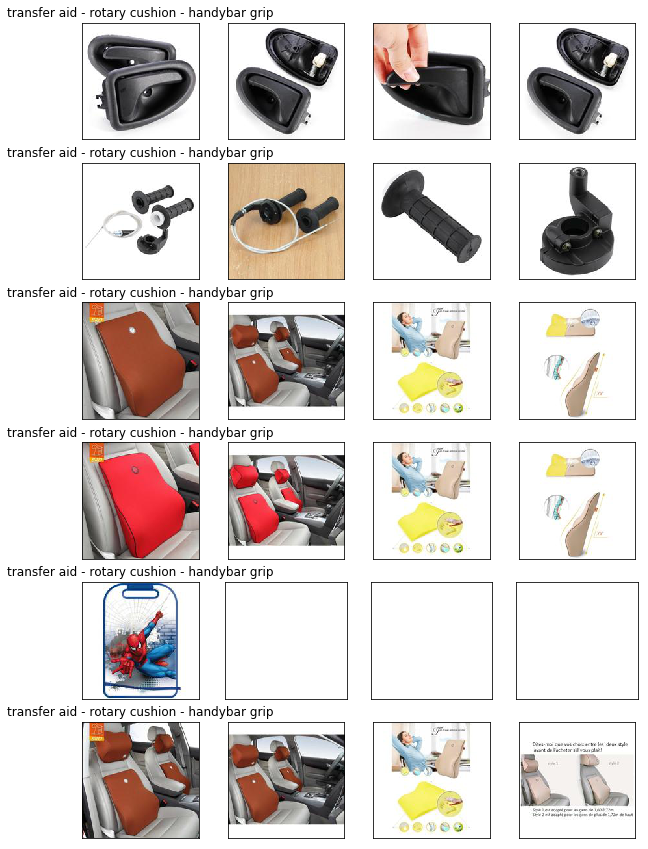

In [58]:
lvl3_str = "AIDE AU TRANSFERT - COUSSIN ROTATIF - POIGNEE HANDYBAR"
# lvl3_str = np.random.choice(categories_df.category_level3.unique())
print "lvl3 category is: ", lvl3_str

num_items = 6
fig, axes = subplots(num_items, 4)
fig.set_size_inches(2.5 * 4, 2.5*num_items)

print translator.translate(lvl3_str.lower(), src='fr').text
for row in range(num_items):
    pic, text = plot_lvl3_products(lvl3_str)
    axes[row, 0].set_title(text)
    for col in range(4):
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])
        sca(axes[row, col])
        if (col < len(pic)):
            imshow(pic[col])

One strategy we considered was using the CNN to categorize either lvl1 or lvl2 class. However, the similarity between products in the same lvl1 and lvl2 classes are limited as well.

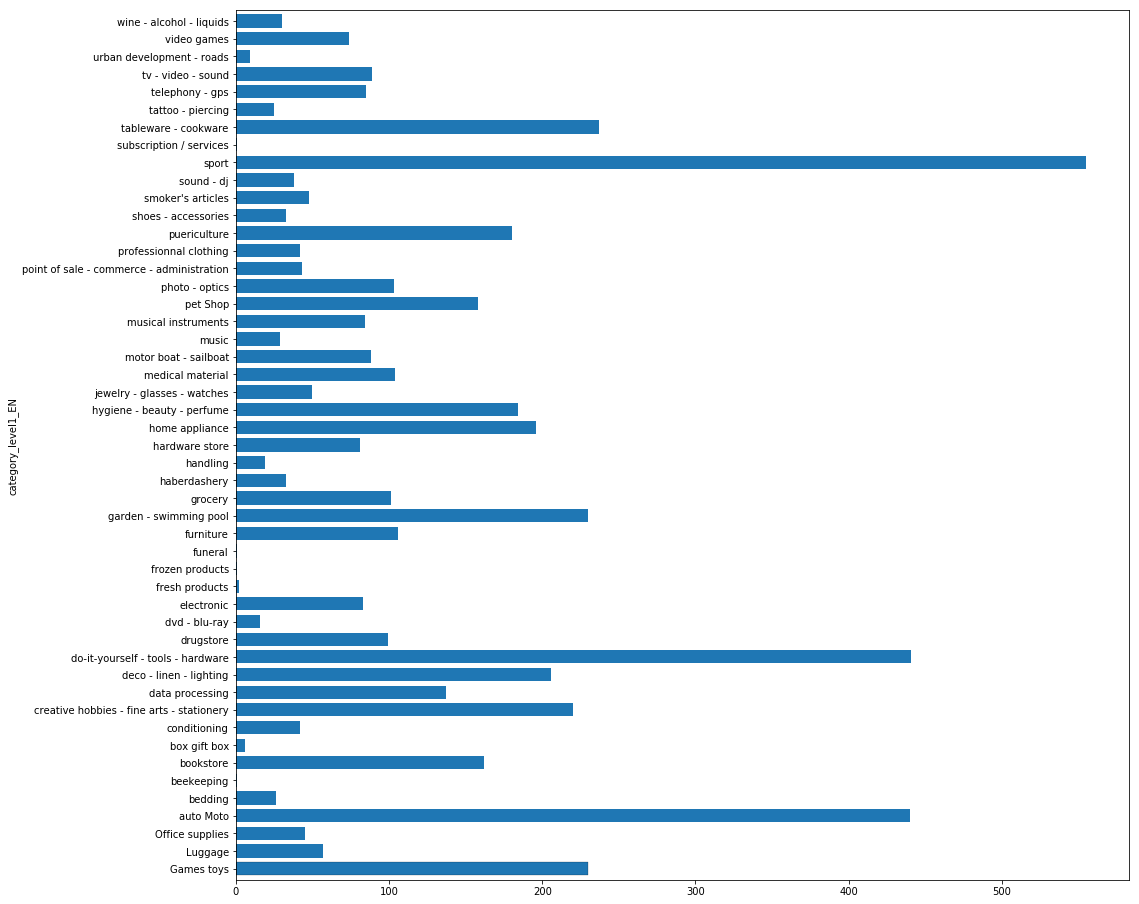

In [45]:
# plotting number of level2 categories per level1 category

figsize(16, 16)
(categories_df
.groupby("category_level1_EN")
.category_level2_EN
.value_counts()
.unstack(level=0)
.sum()
.plot(kind="barh", fontsize=10, edgecolor='k', linewidth=0.2, legend=False, width=0.75))

lvl2 category is:  endoscopy


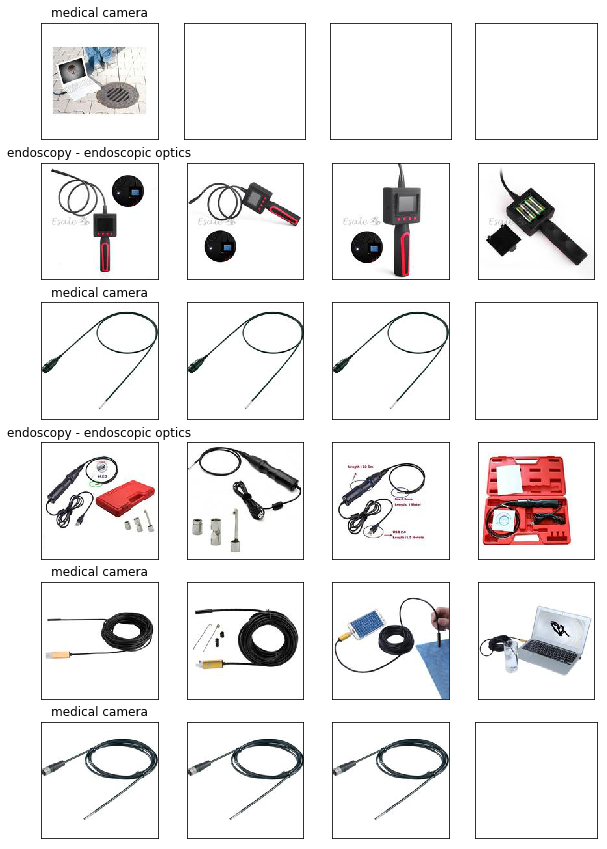

In [59]:
lvl2_str = np.random.choice(categories_df.category_level2.unique())

num_items = 6
fig, axes = subplots(num_items, 4)
fig.set_size_inches(2.5 * 4, 2.5*num_items)

print "lvl2 category is: ", translator.translate(lvl2_str.lower(), src='fr').text
for row in range(num_items):
    pic, text = plot_lvl2_products(lvl2_str)
    axes[row, 0].set_title(text)
    for col in range(4):
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])
        sca(axes[row, col])
        if (col < len(pic)):
            imshow(pic[col])

Here we are showing the number of images per lvl3 group. Around 50% of the classes have less than 200 images. Only 20% of the classes has more than 640 images representing them. Which means for each specific class, the number of samples is not sufficient. 

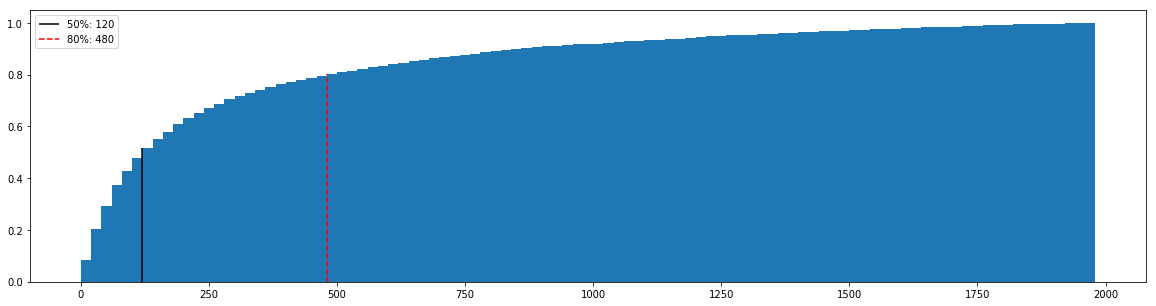

In [60]:
# plotting number of images per lvl3 group
num_samples_per_category = train_images_df.category_idx.value_counts(normalize=False)
bins = np.arange(0,2000,20)

figsize(20, 5)
out = hist(array(num_samples_per_category), bins=bins, cumulative=True, density=True);
# plot 50% 
i1 = abs(out[0]-0.5).argmin()
vlines(out[1][i1], ymin=0, ymax=out[0][i1], label='50%: '+ str(out[1][i1]) )
# plot 80%
i2 = abs(out[0]-0.8).argmin()
vlines(out[1][i2], ymin=0, ymax=out[0][i2], linestyles="dashed", colors='r', label='80%: '+ str(out[1][i2]) )
legend()

# MATT: Can you make this prettier?
Here we plot the number of images per product. 62% of the products are represented by one single image, while the other 38% percent are represented by multiple images.

In [64]:
train_images_df.num_imgs.value_counts(normalize=True)

1    0.618023
2    0.159587
4    0.145584
3    0.076807
Name: num_imgs, dtype: float64

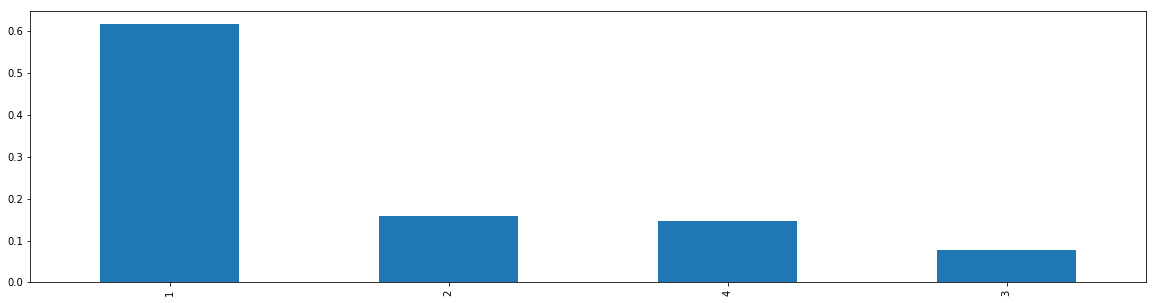

In [63]:
train_images_df.num_imgs.value_counts(normalize=True).plot(kind="bar")

# CNN architecture 

We decide to train a Siamese network which discriminates "same" and "different" a pair of products.

## Rationale, Computation graph & Training

In [65]:
import tensorflow as tf
from src import datagenerator
from src import model
from datetime import datetime
from tensorflow.contrib.data import Iterator

Couldn't import dot_parser, loading of dot files will not be possible.


In [66]:
train_file_path = os.path.join(DATA_DIR, "train_images.csv")
val_file_path = os.path.join(DATA_DIR, "val_images.csv")
checkpoint_path = os.path.join(DATA_DIR, "temp/checkpoints/")
filewriter_path = os.path.join(DATA_DIR, "temp/tensorboard/")

save_freq = 1000
val_freq = 500
batch_size = 10

batches_per_train = 5655916/batch_size
OUT_DIM = 224
IMG_DIM = 180
IMG_CHNL = 3